## 1T. Тема 3.2 Сверточные и полносвязные нейронные сети. Задание

## Задание

Используя набор данных MNIST, создайте свёрточную сеть классификации рукописных цифр. Сравните accuracy с полносвязной сетью из предыдущей темы. Сделайте выводы.

## Загрузка необходимых модулей

In [1]:
import tensorflow as tf
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.datasets import mnist, cifar10 #Библиотеки с базами Mnist, Cifar10
# Подлючаем классы создания последовательной (Sequential) и функциональной (Model) моделей
from tensorflow.keras.models import Sequential, Model
# Подключаем класс Dense - полносвязный слой, и Flatten - данные выстраиваем в линию, одномерные
# Conv2D - свёрточный слой, Input - для подачи входной размерности,
# MaxPooling1D, MaxPooling2D, AveragePooling2D - пулинговые слои для уменьшения размерности
from tensorflow.keras.layers import AveragePooling2D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input
from tensorflow.keras.applications import VGG16 # предобученная нейросеть
# импортируем слои регуляризации Dropout, BatchNormalization для борьбы с переобучением
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam # Подключаем оптимизатор Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator # для создания аугментированных изображениями
from tensorflow.keras import utils #Утилиты для to_categorical
from tensorflow.keras.preprocessing import image #Для отрисовки изображения
from sklearn.metrics import confusion_matrix # для построения матрицы ошибок
from sklearn.utils import resample #для перемешивания выборок
from sklearn.preprocessing import LabelBinarizer # для кодирования в бинарные метки по классам
from sklearn.metrics import classification_report # возвращает точность, полноту, F-меру
from sklearn.model_selection import train_test_split # функция разделения на обучающую и проверочную/тестовую выборку
from sklearn.model_selection import GridSearchCV
import os #для вызова прямо в среде программирования команд операционной оболочки
import os.path # чтобы можно было добавлять цифры (переменные) в путь
from imutils import paths # для загрузки картинок из файлов
import glob # для получения списка имён файлов вместе с путём к ним
import zipfile # для работы с архивами zip
import io # для работы с архивами, input - output
import numpy as np # Подключаем библиотеку numpy
# import pylab # Модуль для построения графиков
import pandas as pd # Библиотека pandas
# from mpl_toolkits.mplot3d import Axes3D # Модуль для трехмерной графики
# from google.colab import files #Для загрузки своей картинки
import matplotlib.pyplot as plt #Отрисовка изображений
import seaborn as sns # seaborn, надстройка визуализации над matplotlib
from PIL import Image #Отрисовка изображений
import cv2 # для загрузки и качественной обработки картинок
import random #Для генерации случайных выборок из датасета
import gc # для очистки памяти от лишних данных
from sklearn.metrics import accuracy_score
#Отрисовывать изображения в ноутбуке, а не в консоль или файл
%matplotlib inline

## Выборки данных, подготовка

### Загружаем данные MNIST

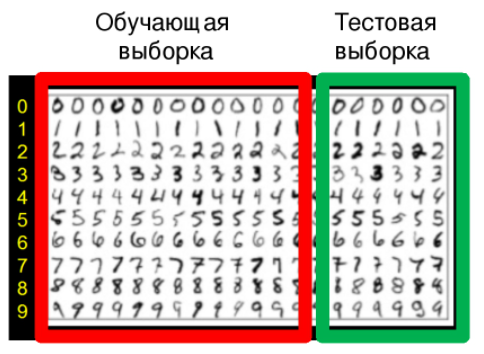

В TensorFlow, частью которого сейчас является Keras, есть тренировочные наборы данных, которые встроены в сам фреймворк. Загрузите датасет MNIST используя tensorflow\keras, либо загрузите его по ссылке : https://storage.googleapis.com/tensorflow/tf-keras-datasets/mnist.npz

In [2]:
# Если датасет загружен локально, то передайте в метод .load_data() параметр path="ваш путь к файлу"
(x_train_org, y_train_org), (x_test_org, y_test_org) = mnist.load_data() #Загрузка данных Mnist

### Пример - выводим на экран картинку цифры из массива

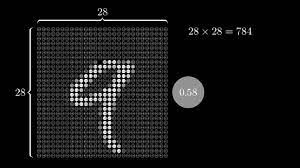

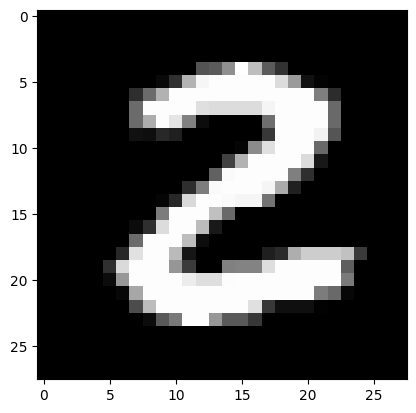

In [3]:
# выводим пример данных
plt.imshow(x_train_org[25], cmap='gray')

### Переводим данные в тип float
Данный тип (с плавающей точкой) необходим сетям Керас для обучения:

In [4]:
x_train_org = x_train_org.astype('float32')
x_test_org = x_test_org.astype('float32')

### Нормализуем данные
В данном случае можно использовать простой вариант. Цветов всего 255, и меняются они через равные промежутки, поэтому удобно не применять скейлер, а поделить массив на 255. Вообще, данные стараются свести все к одинаковому диапазону, обычно 0...1. Это нужно для того, чтобы все признаки одинаково оценивались нейросетью, без значительного перекоса в сторону тех, которые больше и потому сеть им уделяет больше внимания.

In [5]:
# формируем массивы Numpy
x_train_org = np.array(x_train_org)
x_test_org = np.array(x_test_org)

In [6]:
# нормализуем данные
x_train_org = x_train_org/255
x_test_org = x_test_org/255

### Переводим метки в формат One Hot Encoding (OHE)

При кодировании в OHE, вместо числа получаем вектор из всех нулей, кроме одной цифры - вместо нуля на той позиции (индексе), которой соответствует кодируемая цифра, стоит 1.

In [7]:
# используйте модуль utils библиотеки keras, оттуда используйте метод to_categorical как в скринкасте
y_train_org = utils.to_categorical(y_train_org, num_classes=None) # переводим метки в OHE
y_test_org = utils.to_categorical(y_test_org, num_classes=None) # переводим метки в OHE

### Создаём модель Sequential (c помощью функции как в предыдущем задании)

**Sequential** - это последовательная модель, в которой слои нейронной сети укладываются последовательно, как слои в блинном пироге. (Можно взять архитектуру модели по аналогии со скринкастом)

In [8]:
# Не забудьте определить входной размер матрицы img_shape=(28,28,1), при передаче его в первый сверточный слой
# в качестве параметра input_shape
# Далее в последующих слоях можно не указывать input_shape, т.к keras сделает все преобразования за вас
img_shape=(28,28,1)
def get_sequential_model(optimazer = Adam(learning_rate=0.0005), activation = "relu", dropout=0.):
    model = Sequential() # Создаём свёрточную сеть

    # Добавляем свёрточнный слой на 128 нейронов(фильтров, ядер), матрица 3x3 с relu-активацией
    model.add(Conv2D(128, 3, padding = 'same', input_shape=img_shape, activation=activation))
    model.add(BatchNormalization()) # слои регуляризации
    model.add(Conv2D(128, 3, padding = 'same', activation=activation))
    model.add(MaxPooling2D()) # пулинг слой уменьшения размерности Dropout, BatchNormalization
    model.add(BatchNormalization()) # слои регуляризации
    model.add(Dropout(dropout)) # слои регуляризации

    # Добавляем свёрточнный слой на 64 нейрона (фильтра, ядра), матрица 3x3 с relu-активацией
    model.add(BatchNormalization()) # слои регуляризации
    model.add(Conv2D(64, 3, padding = 'same', activation=activation))
    model.add(BatchNormalization()) # слои регуляризации
    model.add(Conv2D(64, 3, padding = 'same', activation=activation))
    model.add(MaxPooling2D()) # пулинг слой уменьшения размерности Dropout, BatchNormalization
    model.add(BatchNormalization()) # слои регуляризации
    model.add(Dropout(dropout)) # слои регуляризации

    # Добавляем свёрточнный слой на 32 нейрона (фильтра, ядра), матрица 3x3 с relu-активацией
    model.add(Conv2D(32, 3, padding = 'same', activation=activation))
    model.add(BatchNormalization()) # слои регуляризации
    model.add(Conv2D(32, 3, padding = 'same', activation=activation))
    model.add(MaxPooling2D()) # пулинг слой уменьшения размерности Dropout, BatchNormalization
    model.add(BatchNormalization()) # слои регуляризации
    model.add(Dropout(dropout)) # слои регуляризации

    # Вытягиваем данные в одномерный вектор только для классификационного слоя
    model.add(Flatten())
    model.add(Dense(70, activation=activation)) # Добавляем полносвязный слой на 70 нейронов с relu-активацией
    model.add(Dense(10, activation="sigmoid")) # Добавляем полносвязный слой на 10 нейронов с softmax-активацией

    # Компилируем модель
    model.compile(loss='categorical_crossentropy', optimizer=optimazer, metrics=["accuracy"])
    #Вывод структуры модели
    print(model.summary())

    return model

In [9]:
my_MNIST_model = get_sequential_model(Adam(learning_rate=0.0005), "relu", 0.5)
history = my_MNIST_model.fit(x_train_org, y_train_org, batch_size=128, epochs=5, validation_data=(x_test_org, y_test_org), verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       1280      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 128)       147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                                                        

#### Выводим график точности на обучающей и валидационной выборке


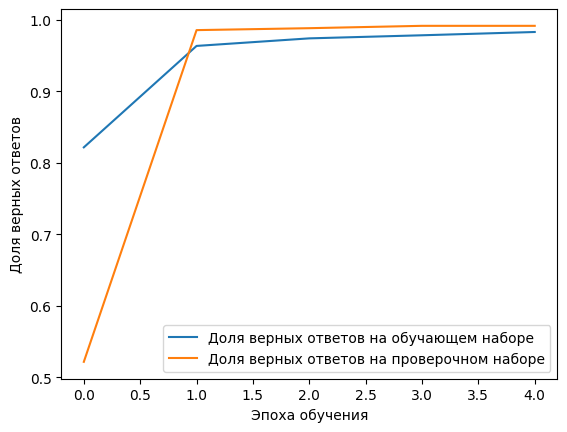

In [10]:
# Выводим график точности на обучающей выборке
# label - имя графика в легенде
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Выводим график точности на проверочной выборке
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Выводим подписи осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Выводим легенду
plt.legend()
plt.show()

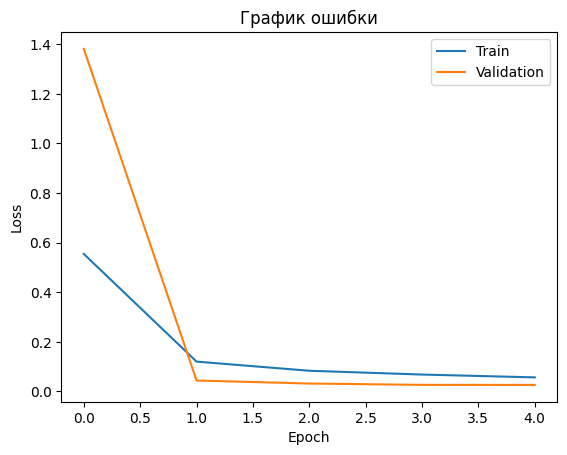

In [11]:
#График ошибки
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

##### Строим матрицу ошибок

In [12]:
y_test_org

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

313/313 [==============================] - 1s 3ms/step


Text(120.72222222222221, 0.5, 'predicted label')

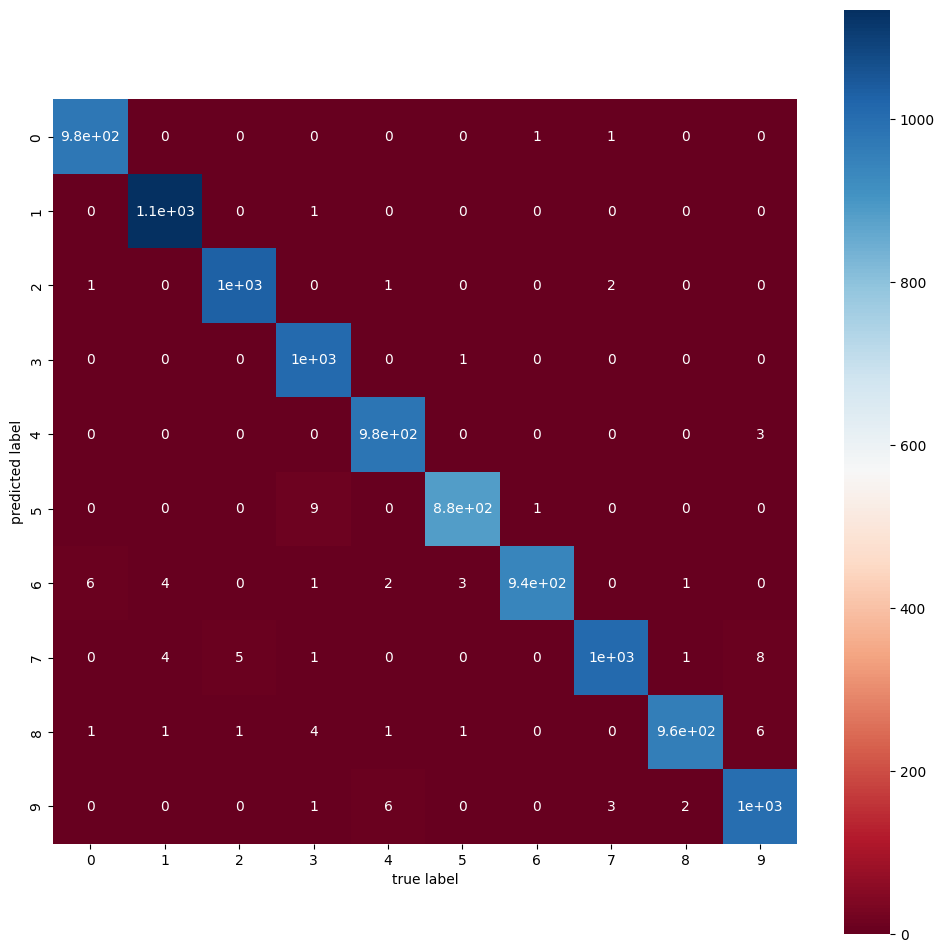

In [13]:
target_test_pred = my_MNIST_model.predict(x_test_org)
target_test_pred = np.argmax(target_test_pred, axis=1)

# cтроим матрицу ошибок
plt.figure(figsize=(12, 12)) # задаем размеры всего рисунка
cm = confusion_matrix(np.argmax(y_test_org, axis=1), target_test_pred) # создаём матрицу ошибок
sns.heatmap(cm, square=True, annot=True, cmap='RdBu')
plt.xlabel('true label')
plt.ylabel('predicted label')

In [14]:
max(history.history['accuracy'])

0.9829666614532471

<p style="border:3px #00B344  solid;">
Вывод: Используя набор данных MNIST, мы создали свёрточную нейронную сеть для классификации рукописных цифр. Сравнивая accuracy с полносвязной сетью из предыдущей темы, можно сделать вывод вывод, что качество модели получилось на порядок выше. Метрика accuracy составила 0.982.
</p>

### 2. Задание ПРО (Не обязательно к выполнению). Используя GridSearch, оптимизируйте свёрточную нейронную сеть для наилучшей классификации. Также, подберите для неё наилучший по параметрам регуляризатор. Сделайте выводы.

In [15]:
# Если вы ловите подобную ошибку:'Adam' object has no attribute 'build', то нужно переустановить тензорфлоу на версию 2.11.0
# https://stackoverflow.com/questions/75088812/attributeerror-adam-object-has-no-attribute-build
# %pip install tensorflow==2.11.0

In [16]:
!nvidia-smi

Fri Aug 11 07:54:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    45W /  70W |   2955MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:
kerasClassifier_model = KerasClassifier(model=get_sequential_model, optimazer = None, activation = None, dropout = None, batch_size = None, epochs = None, verbose=0)

In [18]:
#Количество параметров можно указывать различное, но при этом значительно увеличивается время вычислений
params = {
    'optimazer' : [Adam(learning_rate=0.0005)],
    'activation' : ['relu'],
    'dropout': [0.25, 0.5],
    'batch_size': [128],
    'epochs': [1, 5]
    }

In [19]:
#Подберем оптимальные параметры для модели с помощью GridSearchCV
grid_search = GridSearchCV(estimator=kerasClassifier_model, param_grid=params, cv=5, scoring = 'accuracy')
grid_result = grid_search.fit(x_train_org, y_train_org)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 128)       1280      
                                                                 
 batch_normalization_7 (Batc  (None, 28, 28, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 128)       147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 14, 14, 128)      512       
 hNormalization)                                                 
                                                      

In [20]:
#Наилучшие параметры модели:
best_params = grid_result.best_params_
print("Наилучшие параметры модели: ", best_params)

Наилучшие параметры модели:  {'activation': 'relu', 'batch_size': 128, 'dropout': 0.25, 'epochs': 5, 'optimazer': <keras.optimizers.adam.Adam object at 0x7e01ec52fca0>}


In [21]:
#Посчитаем метрику с наилучшими параметрами
predict_from_grid = grid_result.predict(x_test_org)
accuracy_score(y_test_org, predict_from_grid)

0.9927

Вцелом, в результате проведенной оптимизации и подбора параметров, удалось добиться некоторого улучшения качества модели.
    Наилучшие параметры модели: {'activation': 'relu', 'batch_size': 128, 'dropout': 0.25, 'epochs': 5, 'optimazer': Adam(learning_rate=0.0005)}

    Значения метрики accuracy для различных моделей:
    обученная вручную с подобранными параметрами = 0.982
    predict_from_grid = 0.9927 (KerasClassifier и GridSearchCV)